# Step 1: Satellite Geometry

1_geometry



pip install matplotlib

pip install seaborn

# Step 2: Orbits

## Step 2.1

## Description
Collecting the different orbits to consider, these might be different altitudes and different LTANs

## Inputs
* SCENARIO=SSO_TO_KEPLERIAN_CONVERSION


In [ ]:
# This script processes all input files in the "2_orbit_inputs" folder,

import subprocess
import os
from datetime import datetime

# Paths
input_folder = "1_2_orbit_inputs"
jar_file = "technicalsupport.jar"
log_file = "processing_log.txt"

# Find all .txt input files in the subfolder
input_files = [f for f in os.listdir(input_folder) if f.endswith("_input.txt")]

# Prepare the log
with open(log_file, "w") as log:
    log.write(f"Processing started at {datetime.now()}\n")
    log.write(f"Found {len(input_files)} input files in '{input_folder}'.\n\n")

    # Loop through each input file
    for input_file in input_files:
        input_path = os.path.join(input_folder, input_file)
        output_file = input_file.replace("_input", "_output")
        output_path = os.path.join(input_folder, output_file)

        log.write(f"Processing: {input_file} -> {output_file}\n")
        print(f"Processing {input_file} -> {output_file}...")

        # Build the Java command
        command = [
            "java",
            f"-DINPUT={input_path}",
            f"-DOUTPUT={output_path}",
            "-jar",
            jar_file
        ]

        # Run the command
        result = subprocess.run(command, capture_output=True, text=True)

        # Log results
        if result.returncode == 0:
            log.write(f"  SUCCESS at {datetime.now()}\n\n")
            print(f"  ✅ {input_file} processed successfully.")
        else:
            log.write(f"  ERROR at {datetime.now()}:\n{result.stderr}\n\n")
            print(f"  ❌ Error processing {input_file}. See log for details.")

    log.write(f"Processing finished at {datetime.now()}\n")

print("All files processed. Check processing_log.txt for details.")


## Step 2.2

What it does:
Reads each file in orbits/ ending with _output.txt.

Splits every line on = into key and value.

Builds a wide table:

Row = parameter name (DATE, SEMIMAJOR_AXIS_MET, etc.)

Column = each file’s name (without .txt).

Outputs aggregated_outputs.csv.

In [ ]:
# Aggregating power orbit data from operational outputs

import os
import pandas as pd

# Folder containing the output files
input_folder = "2_orbit_inputs"
output_csv = "aggregated_orbit_outputs.csv"

# Find all *_output.txt files
output_files = [f for f in os.listdir(input_folder) if f.endswith("_output.txt")]

# Dictionary to hold data
data = {}

for file in output_files:
    file_path = os.path.join(input_folder, file)
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Parse key=value pairs
    values = {}
    for line in lines:
        if "=" in line:
            key, val = line.strip().split("=", 1)
            values[key] = val

    # Add to dictionary with filename as column
    data[os.path.splitext(file)[0]] = values

# Convert to DataFrame (keys as rows, files as columns)
df = pd.DataFrame(data)
df.reset_index(inplace=True)
df.rename(columns={"index": "Parameter"}, inplace=True)

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"✅ Aggregated key=value data saved to {output_csv}")


# Step 3: Power Generation

In [1]:
# Generate operating input files from a template and CSV data

import pandas as pd
import os
import re

# File paths
template_path = "operating_template_input.txt"
csv_path = "operational_inputs.csv"
output_dir = "1_4_generated_docs"
os.makedirs(output_dir, exist_ok=True)

# Read template
with open(template_path, 'r') as f:
    template_content = f.read()

# Load CSV
df = pd.read_csv(csv_path)

# Pivot so each scenario is a column
df_pivot = df.set_index('Parameter')
scenarios = df_pivot.columns.tolist()

# Fields to populate
fields = [
    "DATE", "SEMIMAJOR_AXIS_MET", "ECCENTRICITY", "INCLINATION_DEG",
    "RAAN_DEG", "W_DEG", "TA_DEG", "ATTITUDE_MODE", "PRIMARY_VECTOR",
    "SECONDARY_VECTOR", "ABSOLUTE_PATH_TO_FILE", "SPAN_DAYS",
    "PRIMARY_TARGET", "SECONDARY_TARGET"
]

# Generate files
for scenario in scenarios:
    scenario_data = df_pivot[scenario].to_dict()
    content = template_content
    
    # Extract primary/secondary target (or use defaults)
    primary_target = scenario_data.get("PRIMARY_TARGET", "VELOCITY") or "VELOCITY"
    secondary_target = scenario_data.get("SECONDARY_TARGET", "NADIR") or "NADIR"
    
    # Replace fields with values
    for field in fields:
        value = scenario_data.get(field, "")
        if field == "PRIMARY_TARGET":
            value = primary_target
        elif field == "SECONDARY_TARGET":
            value = secondary_target
        content = content.replace(f"{field}=", f"{field}={value}")
    
    # Auto-generate min/max power CSV paths
    min_power = f"./min_{scenario}_{primary_target}_{secondary_target}.csv"
    max_power = f"./max_{scenario}_{primary_target}_{secondary_target}.csv"
    content = content.replace("MINIMUM_ORBIT_POWER_CSV=", f"MINIMUM_ORBIT_POWER_CSV={min_power}")
    content = content.replace("MAXIMUM_ORBIT_POWER_CSV=", f"MAXIMUM_ORBIT_POWER_CSV={max_power}")
    
    # Clean scenario name: remove trailing .digit
    clean_scenario = re.sub(r'\.\d+$', '', scenario)
    
    # Build filename with primary/secondary target
    filename = os.path.join(output_dir, f"{clean_scenario}_{primary_target}_{secondary_target}_input.txt")
    with open(filename, 'w') as f:
        f.write(content)

print(f"Generated {len(scenarios)} files in {output_dir}")

Generated 9 files in 1_4_generated_docs


# Step 5


## Description
Take the input files per orientation and produce the power output

In [2]:
import subprocess
import os

# Folders and paths
input_folder = "1_4_generated_docs"
output_folder = "1_5_operational_outputs"
jar_file = "technicalsupport.jar"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all input files ending with _input.txt
input_files = [f for f in os.listdir(input_folder) if f.endswith("_input.txt")]

for input_file in input_files:
    input_path = os.path.join(input_folder, input_file)
    output_file = input_file.replace("_input.txt", "_output.txt")
    output_path = os.path.join(output_folder, output_file)
    
    # Build the Java command
    command = [
        "java",
        f"-DINPUT={input_path}",
        f"-DOUTPUT={output_path}",
        "-jar",
        jar_file
    ]
    
    print(f"Processing {input_file} -> {output_file}...")
    
    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check result
    if result.returncode == 0:
        print(f"  ✅ Successfully generated {output_file}")
    else:
        print(f"  ❌ Error processing {input_file}: {result.stderr}")

print("All files processed. Outputs saved in 'operational_outputs'.")


Processing orbit_500_ltan_10_output_fault_1_VELOCITY_NADIR_input.txt -> orbit_500_ltan_10_output_fault_1_VELOCITY_NADIR_output.txt...
  ✅ Successfully generated orbit_500_ltan_10_output_fault_1_VELOCITY_NADIR_output.txt
Processing orbit_500_ltan_10_output_fault_2_VELOCITY_NADIR_input.txt -> orbit_500_ltan_10_output_fault_2_VELOCITY_NADIR_output.txt...
  ✅ Successfully generated orbit_500_ltan_10_output_fault_2_VELOCITY_NADIR_output.txt
Processing orbit_500_ltan_10_output_plus10_SUN_GS_input.txt -> orbit_500_ltan_10_output_plus10_SUN_GS_output.txt...
  ✅ Successfully generated orbit_500_ltan_10_output_plus10_SUN_GS_output.txt
Processing orbit_500_ltan_10_output_plus10_SUN_NADIR_input.txt -> orbit_500_ltan_10_output_plus10_SUN_NADIR_output.txt...
  ✅ Successfully generated orbit_500_ltan_10_output_plus10_SUN_NADIR_output.txt
Processing orbit_500_ltan_10_output_plus10_SUN_VELOCITY_input.txt -> orbit_500_ltan_10_output_plus10_SUN_VELOCITY_output.txt...
  ✅ Successfully generated orbit_500_

# Step 6

# Description
Produce the charts that show power produced for the different orbits.
What will be interesting:
1. different operating modes
2. different orbits

In [26]:
# Aggregating power orbit data from operational outputs

import os
import pandas as pd
import re

# Config
input_folder = "1_5_operational_outputs"
output_csv = "aggregated_power_orbit_table.csv"

# Files
files = [f for f in os.listdir(input_folder) if f.endswith("_output.txt")]

# Ordered metrics for final table
ordered_metrics = [
    "ECLIPSE ORBIT PERCENTAGE [%]",
    "SUNLIGHT DURATION [s]",
    "SUNLIGHT ORBIT PERCENTAGE [%]",
    "AVERAGE POWER PER SUNLIGHT [W]",
    "AVERAGE POWER PER ORBIT [W]",
    "AVERAGE POWER PER SUNLIGHT [W],PERCENTAGE OF ORBITS [%]",
    "AVERAGE POWER PER ORBIT [W],PERCENTAGE OF ORBITS [%]"
]

data = {}

for file in files:
    file_path = os.path.join(input_folder, file)
    with open(file_path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    values = {}
    i = 0
    while i < len(lines):
        line = lines[i]
        if line in ordered_metrics[:5]:  # metrics with average/min/max
            # Find average value
            j = i + 1
            while j < len(lines) and "AVERAGE" not in lines[j]:
                j += 1
            if j < len(lines):
                avg_match = re.search(r"AVERAGE\s*=\s*([-+]?[0-9]*\.?[0-9]+)", lines[j])
                if avg_match:
                    values[line] = round(float(avg_match.group(1)), 1)
            i = j + 1
        elif line in ordered_metrics[5:]:  # table metrics
            # Get the highest percentage (≈99%)
            j = i + 1
            max_percentage_val = None
            while j < len(lines) and "," in lines[j]:
                val, perc = lines[j].split(",")
                if float(perc) >= 99:
                    max_percentage_val = round(float(val), 1)
                    break
                j += 1
            if max_percentage_val is not None:
                values[line] = max_percentage_val
            i = j + 1
        else:
            i += 1

    data[file] = values

# Create DataFrame with files as columns and metrics as rows
df = pd.DataFrame(data)
df = df.reindex(ordered_metrics)  # enforce row order

# Save CSV
df.to_csv(output_csv)
print(f"Aggregated table saved to {output_csv}")



Aggregated table saved to aggregated_power_orbit_table.csv


In [27]:
# Generate bar charts for average power per orbit

import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# --- Config ---
input_csv = "aggregated_power_orbit_table.csv"
output_folder = "1_6_analysis_charts"
metric = "AVERAGE POWER PER ORBIT [W]"

os.makedirs(output_folder, exist_ok=True)

# --- Load Data ---
df = pd.read_csv(input_csv, index_col=0)
power_row = df.loc[metric]  # Extract the row with our metric

# --- Parse filename components ---
data = []
for filename, value in power_row.items():
    alt_match = re.search(r'orbit_(\d+)', filename)
    ltan_match = re.search(r'ltan_(\d+)', filename)
    mode_match = re.search(r'_(VELOCITY|SUN)_(NADIR|SUN|GS)', filename)

    altitude = int(alt_match.group(1)) if alt_match else None
    ltan = int(ltan_match.group(1)) if ltan_match else None
    mode = f"{mode_match.group(1)}-{mode_match.group(2)}" if mode_match else "UNKNOWN"

    data.append({
        "Filename": filename,
        "Mode": mode,
        "Altitude": altitude,
        "LTAN": ltan,
        "Power": float(value)
    })

df_parsed = pd.DataFrame(data)

# --- Generate one chart per Mode ---
for mode in df_parsed["Mode"].unique():
    subset = df_parsed[df_parsed["Mode"] == mode].sort_values(by=["Altitude", "LTAN"])
    
    labels = [f"Alt {row['Altitude']}\nLTAN {row['LTAN']}" for _, row in subset.iterrows()]
    values = subset["Power"].values

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color="skyblue")
    plt.title(f"Average Power per Orbit [W] - {mode}")
    plt.ylabel("Power [W]")
    plt.xlabel("Scenario (Altitude & LTAN)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save chart
    chart_path = os.path.join(output_folder, f"{mode}_bar_chart.png")
    plt.savefig(chart_path, dpi=300)
    plt.close()

print(f"Charts saved in {output_folder}")


Charts saved in 1_6_analysis_charts


In [28]:
# Generate normalized power generation charts for each attitude combination

import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Input and output folders
input_folder = "1_5_operational_outputs"
output_folder = "1_6_analysis_charts"
os.makedirs(output_folder, exist_ok=True)

# Attitude combinations to search for
targets = ["SUN_NADIR", "VELOCITY_NADIR", "VELOCITY_SUN", "VELOCITY_GS", "SUN_VELOCITY", "SUN_GS"]

for target in targets:
    # Find all matching files for this target
    file_pattern = os.path.join(input_folder, f"min_*{target}*.csv")
    files = glob.glob(file_pattern)

    if not files:
        print(f"No matching files found for {target}.")
        continue

    plt.figure(figsize=(10, 6))

    for file in files:
        try:
            # Read CSV
            df = pd.read_csv(file)
            # Ensure the columns exist
            if "ELAPSED_TIME_SEC" in df.columns and "POWER_GENERATION_WATTS" in df.columns:
                # Normalize time so it starts at 0
                time = df["ELAPSED_TIME_SEC"] - df["ELAPSED_TIME_SEC"].iloc[0]
                power = df["POWER_GENERATION_WATTS"]
                plt.plot(time, power, label=os.path.basename(file))
            else:
                print(f"Skipping {file}: Required columns not found.")
        except Exception as e:
            print(f"Error reading {file}: {e}")

    plt.xlabel("Elapsed Time (sec) [Normalized]")
    plt.ylabel("Power Generation (Watts)")
    plt.title(f"Normalized Power Generation vs Time ({target} scenarios)")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot as a PNG
    output_path = os.path.join(output_folder, f"normalized_power_{target}.png")
    plt.savefig(output_path, dpi=300)
    plt.close()

    print(f"Saved chart for {target} to {output_path}")


Saved chart for SUN_NADIR to 1_6_analysis_charts\normalized_power_SUN_NADIR.png
Saved chart for VELOCITY_NADIR to 1_6_analysis_charts\normalized_power_VELOCITY_NADIR.png
Saved chart for VELOCITY_SUN to 1_6_analysis_charts\normalized_power_VELOCITY_SUN.png
Saved chart for VELOCITY_GS to 1_6_analysis_charts\normalized_power_VELOCITY_GS.png
Saved chart for SUN_VELOCITY to 1_6_analysis_charts\normalized_power_SUN_VELOCITY.png
Saved chart for SUN_GS to 1_6_analysis_charts\normalized_power_SUN_GS.png


In [29]:
# Generate one combined normalized power generation chart for all attitude combinations

import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Input and output folders
input_folder = "1_5_operational_outputs"
output_folder = "1_6_analysis_charts"
os.makedirs(output_folder, exist_ok=True)

# Attitude combinations to search for
targets = ["SUN_NADIR", "VELOCITY_NADIR", "VELOCITY_SUN", "VELOCITY_GS", "SUN_VELOCITY", "SUN_GS"]

plt.figure(figsize=(12, 7))  # One combined figure

for target in targets:
    # Find all matching files for this target
    file_pattern = os.path.join(input_folder, f"min_*{target}*.csv")
    files = glob.glob(file_pattern)

    if not files:
        print(f"No matching files found for {target}.")
        continue

    for file in files:
        try:
            # Read CSV
            df = pd.read_csv(file)
            # Ensure the columns exist
            if "ELAPSED_TIME_SEC" in df.columns and "POWER_GENERATION_WATTS" in df.columns:
                # Normalize time so it starts at 0
                time = df["ELAPSED_TIME_SEC"] - df["ELAPSED_TIME_SEC"].iloc[0]
                power = df["POWER_GENERATION_WATTS"]
                plt.plot(time, power, label=f"{target} - {os.path.basename(file)}")
            else:
                print(f"Skipping {file}: Required columns not found.")
        except Exception as e:
            print(f"Error reading {file}: {e}")

plt.xlabel("Elapsed Time (sec) [Normalized]")
plt.ylabel("Power Generation (Watts)")
plt.title("Normalized Power Generation vs Time (All Scenarios)")
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()

# Save the combined plot as a PNG
output_path = os.path.join(output_folder, "normalized_power_all_scenarios.png")
plt.savefig(output_path, dpi=300)
plt.close()

print(f"Saved combined chart to {output_path}")


Saved combined chart to 1_6_analysis_charts\normalized_power_all_scenarios.png


## What it does:


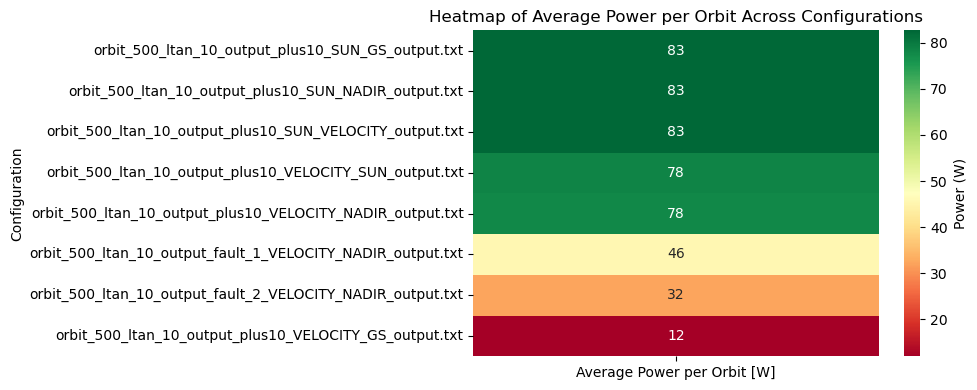

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load updated aggregated power per orbit table ===
aggregated_power = pd.read_csv("aggregated_power_orbit_table.csv")

# === Transpose for easier handling ===
aggregated_power_t = aggregated_power.set_index('Unnamed: 0').T

# === Extract "AVERAGE POWER PER ORBIT [W]" and convert ===
avg_power = aggregated_power_t["AVERAGE POWER PER ORBIT [W]"].astype(float)

# === Create DataFrame for heatmap ===
heatmap_df = avg_power.to_frame(name="Average Power per Orbit [W]")

# === Plot heatmap ===
plt.figure(figsize=(10, len(heatmap_df) * 0.5))
sns.heatmap(
    heatmap_df.sort_values("Average Power per Orbit [W]", ascending=False),
    annot=True,
    cmap="RdYlGn",
    cbar_kws={'label': 'Power (W)'}
)
plt.title("Heatmap of Average Power per Orbit Across Configurations")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Load updated aggregated power per orbit table ===
aggregated_power = pd.read_csv("aggregated_power_orbit_table.csv")

# === Transpose for easier handling ===
aggregated_power_t = aggregated_power.set_index('Unnamed: 0').T

# === Extract "AVERAGE POWER PER ORBIT [W]" and convert ===
avg_power = aggregated_power_t["AVERAGE POWER PER ORBIT [W]"].astype(float)

# === Create DataFrame for heatmap ===
heatmap_df = avg_power.to_frame(name="Average Power per Orbit [W]")

# === Output folder ===
output_folder = "1_6_analysis_charts"
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "average_power_per_orbit_heatmap.png")

# === Plot heatmap ===
plt.figure(figsize=(10, len(heatmap_df) * 0.5))
sns.heatmap(
    heatmap_df.sort_values("Average Power per Orbit [W]", ascending=False),
    annot=True,
    cmap="RdYlGn",
    cbar_kws={'label': 'Power (W)'}
)
plt.title("Heatmap of Average Power per Orbit Across Configurations")
plt.ylabel("Configuration")
plt.tight_layout()

# === Save as PNG ===
plt.savefig(output_path, dpi=300)
plt.close()

print(f"Heatmap saved to {output_path}")


Heatmap saved to 1_6_analysis_charts\average_power_per_orbit_heatmap.png
